In [1]:
import pandas as pd
import os
import polars as pl
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import numpy as np
from AlvaroSantanaSanchez.utils import EnsembleFilter
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns

TRAIN_PATH = "../data/train.csv"
TEST_PATH = "../data/test.csv"
print(os.getcwd())

C:\Users\alvaro.santana\PycharmProjects\MineriaMetroPT-3\AlvaroSantanaSanchez


In [2]:
#Valores encontrados durante ajuse de hiperparametros AdaBoost
best_params_ada_boost, best_params_CT = ({'learning_rate': 1, 'n_estimators': 200},
                                         {'criterion': 'gini',
                                          'max_depth': 3,
                                          'min_samples_leaf': 5,
                                          'min_samples_split': 2,
                                          'splitter': 'best',
                                          'class_weight': {0: 1, 1: 1}
                                          }
                                         )

best_params_logistic_regression = {'C': 1000.0, 'class_weight': {0: 1, 1: 10}, 'penalty': 'l1'}

## Carga del dataset y generación de particiones

In [3]:
train = pl.read_csv(TRAIN_PATH)
test = pl.read_csv(TEST_PATH)
skew_columns = [c for c in train.columns if "skew" in c]
train = train.select(pl.exclude(skew_columns))
test = test.select(pl.exclude(skew_columns))


In [4]:

X_train = train.select(pl.exclude("is_anomaly")).to_pandas()
y_train = train.select("is_anomaly").to_series().to_list()

X_test = test.select(pl.exclude("is_anomaly")).to_pandas()
y_test = test.select("is_anomaly").to_series().to_list()


## Eliminacion del ruido

Buscamos eliminar ruido de los casos no anomalos.

In [5]:
X_train_clean, y_train_clean, noisy_indice = EnsembleFilter(X_train.to_numpy(), np.array(y_train, dtype=np.float32),
                                                            k=5, voting='consensus')

clean_train = train.with_row_index().filter((~pl.col("index").is_in(noisy_indice))).select(pl.exclude("index"))
#Comprobamos si se han filtrado algunas instancias
pl.concat([
    train.group_by("is_anomaly").len().with_columns(pl.lit("original").alias("dataframe")),
    clean_train.group_by("is_anomaly").len().with_columns(pl.lit("limpio").alias("dataframe"))
]).sort(by=["dataframe", "is_anomaly"])


is_anomaly,len,dataframe
bool,u32,str
false,4442,"""limpio"""
true,209,"""limpio"""
false,4445,"""original"""
true,217,"""original"""


In [6]:
#Eliminado el ruido volvemos a cargar el conjunto de entrenamiento
X_train = clean_train.select(pl.exclude("is_anomaly")).to_pandas()
y_train = clean_train.select("is_anomaly").to_series().to_list()

## Escalado de datos y PCA

In [7]:

Scaler = StandardScaler(with_mean=True, with_std=False)
X_scaled = Scaler.fit_transform(X=X_train[[a for a in X_train.columns if "fold" != a]])
X_scaled = pd.DataFrame(X_scaled)
X_scaled.columns = [a for a in X_train.columns if "fold" != a]


Text(0, 0.5, 'Varianza acumulada')

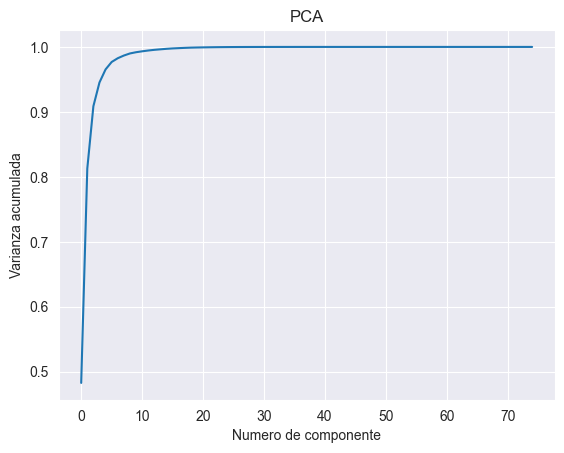

In [8]:
pca = PCA().fit(X_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('PCA')
plt.xlabel('Numero de componente')
plt.ylabel('Varianza acumulada')

In [9]:
pca = PCA(n_components=30)
pca_result = pca.fit_transform(X_scaled)
pca_result.shape

(4651, 30)

In [10]:
X_scaled = pd.DataFrame(pca_result)
X_scaled["fold"] = X_train["fold"]
X_scaled.columns = X_scaled.columns.astype(str)
# X_scaled.columns = X_train.columns

# Ajuste de hiperparametros LogisticRegresion

In [11]:
seed = 140421
np.random.seed(seed)

target_column = 'is_anomaly'
fold_column = 'fold'


def get_cv_iterable(
        folds: list,
        fold_column: str,
        train: pd.DataFrame,
):
    for fold in folds:
        test_indexes = train[train[fold_column] == fold].index
        train_indexes = train[train[fold_column] != fold].index
        yield (train_indexes, test_indexes)


# X_test = test_data[feature_columns]
# y_test = test_data[target_column]

# Set up cross-validation using the 'folds' column
folds = train["fold"].unique().to_list()
grid = {
    "C": np.logspace(-3, 3, 7),
    "penalty": ["l2", "l1"],
    'class_weight': ['balanced', {0: 1, 1: 10}, {0: 1, 1: 20}]
}

if not best_params_logistic_regression:
    cv = GridSearchCV(
        estimator=LogisticRegression(solver='liblinear', max_iter=10000),
        param_grid=grid,
        cv=get_cv_iterable(folds, fold_column, X_scaled),
        scoring=[
            "f1",
            "recall",
            "precision",
            "accuracy"
        ],
        refit="f1",
    )

    cv.fit(X_scaled, y_train)

    with pd.option_context("display.max_columns", 33):
        display(pd.DataFrame(cv.cv_results_)["mean_test_f1"].max())



In [12]:
if not best_params_logistic_regression:
    cv_results_df = pd.DataFrame(cv.cv_results_)
    best_params_row = cv_results_df.loc[cv_results_df["mean_test_f1"].idxmax()]
    best_params_logistic_regression = best_params_row["params"]
print("Mejores parámetros regresión logística", best_params_logistic_regression)

Mejores parámetros regresión logística {'C': 1000.0, 'class_weight': {0: 1, 1: 10}, 'penalty': 'l1'}


## Entrenamiento

In [13]:
logistic_regressor = LogisticRegression(solver="liblinear", **best_params_logistic_regression, max_iter=10000).fit(
    X_scaled[[a for a in X_scaled.columns if "fold" != a]], y_train)

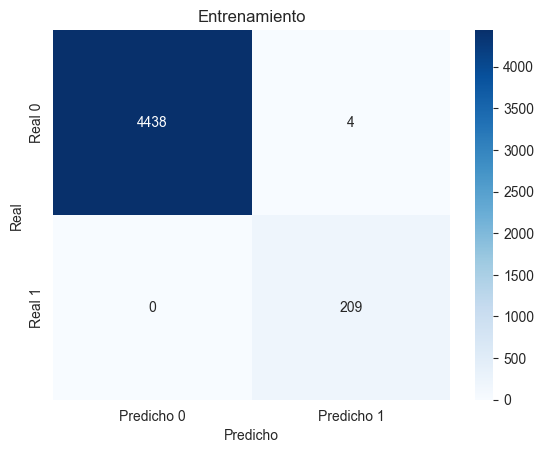

In [14]:
#Matriz de confusion entrenamiento
cm = confusion_matrix(y_train, logistic_regressor.predict(X_scaled[[a for a in X_scaled.columns if "fold" != a]]))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicho 0', 'Predicho 1'],
            yticklabels=['Real 0', 'Real 1'])
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Entrenamiento')
plt.show()

## Test: LogisticRegression

In [15]:
test_scaled = pd.DataFrame(Scaler.transform(X_test))
test_scaled.columns = X_test.columns
test_scaled_pca = pd.DataFrame(pca.transform(test_scaled))
test_scaled_pca.columns = [a for a in X_scaled.columns if a != "fold"]
predictions = logistic_regressor.predict(test_scaled_pca)
print("f1_score", f1_score(test.select("is_anomaly").to_series().to_list(), predictions))
print("recall", recall_score(test.select("is_anomaly").to_series().to_list(), predictions))
print("precision", precision_score(test.select("is_anomaly").to_series().to_list(), predictions))
print("accuracy", accuracy_score(test.select("is_anomaly").to_series().to_list(), predictions))
print("confusion matrix", confusion_matrix(test.select("is_anomaly").to_series().to_list(), predictions))


f1_score 0.9178082191780822
recall 0.9054054054054054
precision 0.9305555555555556
accuracy 0.991130820399113
confusion matrix [[1274    5]
 [   7   67]]


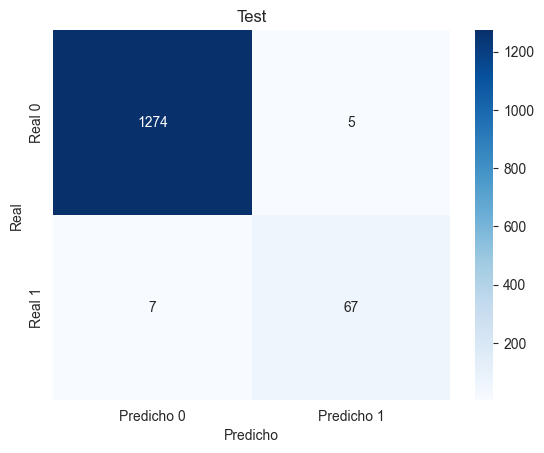

In [16]:
cm = confusion_matrix(y_test, predictions)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicho 0', 'Predicho 1'],
            yticklabels=['Real 0', 'Real 1'])
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Test')
plt.show()

# ADABOOST

## Ajuste hiperparámetros: AdaBoost

In [17]:
if not best_params_ada_boost or not best_params_CT:
    grid = {"estimator__criterion": ["gini", "entropy"],
            "estimator__splitter": ["best", "random"],
            "estimator__max_depth": [3, 5, 10],  # Limit tree depth to avoid overfitting
            "estimator__min_samples_split": [2, 5, 10],  # Minimum samples to split an internal node
            "estimator__min_samples_leaf": [1, 2, 5],  # Minimum samples required in a leaf node
            "estimator__class_weight": [{0: 1, 1: 1}, {0: 1, 1: 10}, {0: 1, 1: 20}, {0: 1, 1: 40}, {0: 1, 1: 100}],
            "n_estimators": [1, 2, 10, 50, 100, 200],  # Number of weak learners
            "learning_rate": [0.01, 0.1, 0.5, 1],
            }

    DTC = DecisionTreeClassifier(random_state=seed)

    cv2 = GridSearchCV(
        estimator=AdaBoostClassifier(algorithm='SAMME', estimator=DTC, random_state=seed),
        param_grid=grid,
        cv=get_cv_iterable(folds, fold_column, X_train),
        scoring=[
            "f1",
            "recall",
            "precision",
            "accuracy"
        ],
        refit="f1",
    )

    cv2.fit(X_train, y_train)

    with pd.option_context("display.max_columns", 33):
        display(pd.DataFrame(cv2.cv_results_))
    pl.DataFrame(cv2.cv_results_)


Fase 2: Estimación de pesos

In [18]:
if not best_params_ada_boost or not best_params_CT:
    cv_results_df = pd.DataFrame(cv2.cv_results_)
    best_params_row = cv_results_df.loc[cv_results_df["mean_test_f1"].idxmax()]
    params = best_params_row["params"]
    best_params_CT = {a.split("estimator__")[-1]: b for a, b in params.items() if "estimator__" in a}
    best_params_ada_boost = {a: b for a, b in best_params_ada_boost.items() if "estimator__" not in a}
print("Mejores parámetros AdaBoost", best_params_ada_boost)
print("Mejores parámetros árbol de decisión", best_params_CT)

Mejores parámetros AdaBoost {'learning_rate': 1, 'n_estimators': 200}
Mejores parámetros árbol de decisión {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2, 'splitter': 'best', 'class_weight': {0: 1, 1: 1}}


## Entrenemiento

In [19]:
clfAda = AdaBoostClassifier(algorithm='SAMME', **best_params_ada_boost,
                            estimator=DecisionTreeClassifier(**best_params_CT), random_state=seed).fit(
    X_train[[a for a in X_train.columns if "fold" != a]], y_train)

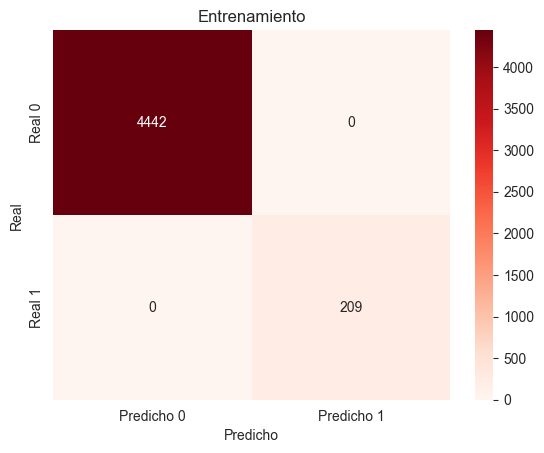

In [20]:
cm = confusion_matrix(y_train,  clfAda.predict(X_train[[a for a in X_train.columns if "fold" != a]]))

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Predicho 0', 'Predicho 1'],
            yticklabels=['Real 0', 'Real 1'])
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Entrenamiento')
plt.show()

## Evaluación AdaBoost

In [21]:
predictions = clfAda.predict(test.select([a for a in X_test.columns if "fold" != a]))
print("f1_score", f1_score(test.select("is_anomaly").to_series().to_list(), predictions))
print("recall", recall_score(test.select("is_anomaly").to_series().to_list(), predictions))
print("precision", precision_score(test.select("is_anomaly").to_series().to_list(), predictions))
print("accuracy", accuracy_score(test.select("is_anomaly").to_series().to_list(), predictions))
print("confusion matrix", confusion_matrix(test.select("is_anomaly").to_series().to_list(), predictions))


f1_score 0.9395973154362416
recall 0.9459459459459459
precision 0.9333333333333333
accuracy 0.9933481152993349
confusion matrix [[1274    5]
 [   4   70]]


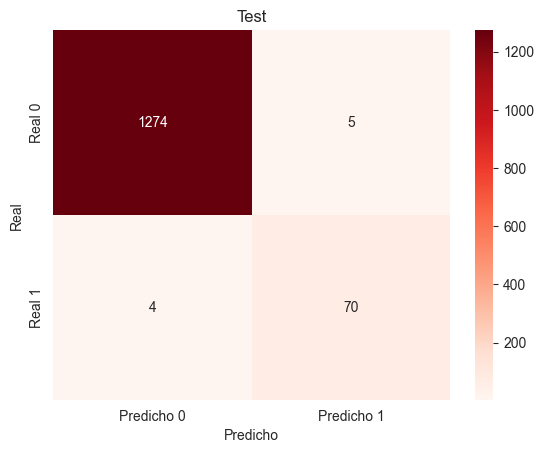

In [22]:
cm = confusion_matrix(y_test,  predictions)

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Predicho 0', 'Predicho 1'],
            yticklabels=['Real 0', 'Real 1'])
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Test')
plt.show()

In [23]:
from sklearn.model_selection import learning_curve

train_mean_all = []
train_size_all = []
test_mean_all = []

#Curva de regresion logistica
model = LogisticRegression(solver="liblinear", **best_params_logistic_regression, max_iter=10000)

(train_sizes,
 train_scores,
 test_scores) = learning_curve(model, X_scaled, y_train, cv=get_cv_iterable(folds, fold_column, X_train), scoring="f1")

train_size_all.append(train_sizes)
train_mean_all.append(np.mean(train_scores, axis=1))
train_std = np.std(train_scores, axis=1)

test_mean_all.append(np.mean(test_scores, axis=1))

#Ada Boost
model = AdaBoostClassifier(algorithm='SAMME', **best_params_ada_boost,
                           estimator=DecisionTreeClassifier(**best_params_CT), random_state=seed).fit(
    X_train[[a for a in X_train.columns if "fold" != a]], y_train)

(train_sizes,
 train_scores,
 test_scores) = learning_curve(model, X_scaled, y_train, cv=get_cv_iterable(folds, fold_column, X_train), scoring="f1")

train_size_all.append(train_sizes)
train_mean_all.append(np.mean(train_scores, axis=1))
train_std = np.std(train_scores, axis=1)

test_mean_all.append(np.mean(test_scores, axis=1))

#Curva

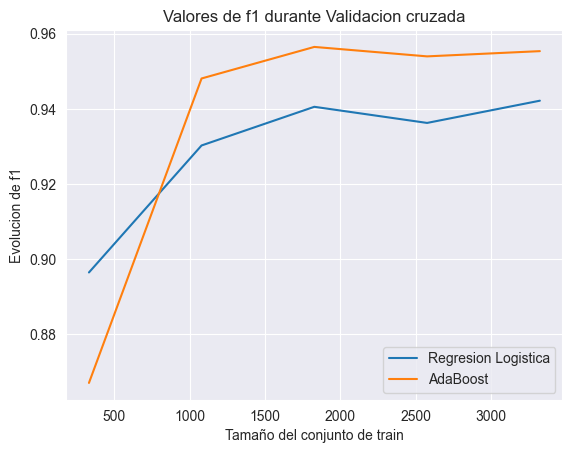

In [24]:
plt.plot(train_size_all[0], test_mean_all[0], label="Regresion Logistica")
plt.plot(train_size_all[1], test_mean_all[1], label="AdaBoost")
plt.title("Valores de f1 durante Validacion cruzada")
plt.xlabel("Tamaño del conjunto de train")
plt.ylabel("Evolucion de f1")
plt.legend()
